 - 강화학습
   - 자전거 타기
   - 스키너의 행동심리학
   - 바둑 ,비디오 게임

- 학습사이클
  - 행동(에이전트) ->상태변화 ->보상

- 다중 손잡이 밴딧 문제
- OpenAI  gym라이브러리

- 에이전트/환경 : 특정환경에서 행동을 취함, 행동에 대한 결과(보상)
- 상태 : 현재상태, 에이전트가 이 상태를 바탕으로 행동을
결정
- 행동 : 에이전트가 취할수 있는 선택
- 보상 : 행동에 대한 피드백
- 정책 : 에이전트가 특정상태에서 어떤 행동알 선택할지 전략
- 가치 함수 : 보상의 총합

 - 다중손잡이 밴딧
  - 1을 넣고 여러손잡이중에서 하나를  골라서 당기면 1잃거나 얻음
  - 손잡이마다가 승률이정해져 있음, 사용자는 모름
  - 행동의 집합(손잡이1,손잡이2,손잡이3,손잡이4,손잡이5)
  - 보상의 집합 - {-1. 1}
  - 행동 -> 상태 변화 -> 보상의 학습 사이클에서 상태가 없는 단순한 문제


In [ ]:
# 탐험형 탐색
  # 처음부터 끝가지 무작위로 선택하는 극단적인 탐험형 탐색
# 탐사형 정책
  # 몇번 시도해 보고 이후에는 그때까의 승률이 가장 높은 손잡이만 당기는
# 균형이 중요함 : 현재까지 높은 확률을 보이는 손잡이를 더 자주 당기지만 일정한 비율로 다른 손잡이도 시도하는 정책
# 에피소드 : 강화학습에서 게임시작~마칠때 까지


In [23]:
import numpy as np
arms_profit = [0.4,0.12,0.52,0.6,0.25]  # 승률
n_arms = len(arms_profit)
# 손잡이를 당기는 횟수(에피소드의 길이)
n_trai = 1000
# 손잡이 당기는 시뮬레이션 함수
def pull_bandit(handle):
  q = np.random.random()  # 0~ 1사이의 난수
  if q < arms_profit[handle]:
    return 1
  else:
    return -1
# 랜덤 탐색정책 : 무작위로 손잡이를 당기고 보상을 기록하는 함수
def random_exploration():
  episode = []
  num = np.zeros(n_arms)
  wins = np.zeros(n_arms)
  for i in range(n_trai):
    h = np.random.randint(0,n_arms)
    reward = pull_bandit(h)
    episode.append([h,reward])
    num[h] += 1
    wins[h] += reward
  return episode,(num,wins)

e,r = random_exploration()
r
result = [ r[1][i]/r[0][i] if r[0][i] > 0 else 0.0  for i in range(n_arms) ]
print(f"손잡이별 승리 확률 : {result}")
wins = [ 2*r[1][i] - r[0][i] for i in range(n_arms)]  # 2*승리횟수 - 당긴횟수
print(f"손잡이별 수익 : {wins}")


손잡이별 승리 확률 : [-0.1504424778761062, -0.7754010695187166, 0.058823529411764705, 0.2708333333333333, -0.5384615384615384]
손잡이별 수익 : [-294.0, -477.0, -165.0, -88.0, -432.0]


In [3]:
!pip install gym
!pip install torch torchvision torchaudio

Episode: 0, Reward: 13.0, Epsilon: 0.99
Episode: 100, Reward: 11.0, Epsilon: 0.60
Episode: 200, Reward: 10.0, Epsilon: 0.37
Episode: 300, Reward: 41.0, Epsilon: 0.22
Episode: 400, Reward: 30.0, Epsilon: 0.13
Episode: 500, Reward: 41.0, Epsilon: 0.08
Episode: 600, Reward: 114.0, Epsilon: 0.05
Episode: 700, Reward: 107.0, Epsilon: 0.03
Episode: 800, Reward: 111.0, Epsilon: 0.02
Episode: 900, Reward: 243.0, Epsilon: 0.01


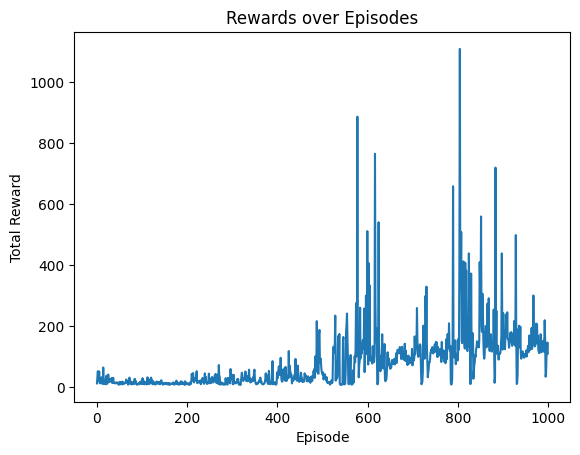

In [9]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# DQN 네트워크 정의
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)  # state_size 관측값의 차원
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)  # 가능한 행동의 수

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN 에이전트 클래스 정의
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # 할인 계수
        self.epsilon = 1.0  # 탐사 확률
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return np.argmax(q_values.detach().numpy())

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model(torch.FloatTensor(next_state)).detach().numpy())
            target_f = self.model(torch.FloatTensor(state))
            target_f = target_f.clone()  # Clone the target_f tensor to avoid in-place modification
            target_f[action] = target  # 1차원 텐서로 처리
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(torch.FloatTensor(state)), target_f)
            loss.backward()
            self.optimizer.step()

# Hyperparameters
EPISODES = 1000
BATCH_SIZE = 32

# 환경 초기화
env = gym.make("CartPole-v1", new_step_api=True)  # 새로운 API 사용
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

rewards = []

# DQN 학습
for e in range(EPISODES):
    state = env.reset()  # 상태 초기화
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)  # 새로운 API에 맞게 수정
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.replay(BATCH_SIZE)
    rewards.append(total_reward)

    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    if e % 100 == 0:
        print(f"Episode: {e}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# 보상 시각화
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

env.close()
